In [1]:
%run ~/relmapping/annot/notebooks/__init__.ipynb

/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


os.getcwd(): /mnt/beegfs/scratch_copy/ahringer/jj374/lab/relmapping


In [2]:
# Build gdf
def addon_H3K36me3_gene(df_regl_arg):
    random.seed(1)
    def H3K36me3_gene_id_(prom_fwd_gene_id, prom_rev_gene_id, associated_gene_id):
        if yp.is_gene_id(prom_fwd_gene_id) and yp.is_gene_id(prom_rev_gene_id):
            return random.choice([prom_fwd_gene_id, prom_rev_gene_id])
        elif yp.is_gene_id(prom_fwd_gene_id):
            return prom_fwd_gene_id
        elif yp.is_gene_id(prom_rev_gene_id):
            return prom_rev_gene_id
        else:
            return random.choice(associated_gene_id.split(','))

    df_regl_ = df_regl_arg.copy()
    df_regl_['H3K36me3_gene_id'] = [*map(H3K36me3_gene_id_, 
                                         df_regl_arg['promoter_gene_id_fwd'],
                                         df_regl_arg['promoter_gene_id_rev'],
                                         df_regl_arg['associated_gene_id'])]
    print('%d pre-filter' % (len(df_regl_,)))
    df_regl_ = df_regl_.query('H3K36me3_gene_id != "."').reset_index(drop=True)
    print('%d post-filter' % (len(df_regl_,)))

    col_ = ['chrom', 'start', 'end', 'strand', 'gene_id']
    df_genes = pd.read_csv('WS260_ce10/WS260_ce10.genes_by_CV.tsv', sep='\t')[col_]\
        .drop_duplicates(subset=['gene_id']) # CV table has two duplicate gene records where a gene is annotated in *two* distinct operons

    df_genes.columns = [
        'H3K36me3_gene_chrom',
        'H3K36me3_gene_start',
        'H3K36me3_gene_end',
        'H3K36me3_gene_strand',
        'H3K36me3_gene_id',
    ]

    df_regl = df_regl_.merge(df_genes, how='left', left_on='H3K36me3_gene_id', right_on='H3K36me3_gene_id')
    m_ = ~(df_regl['H3K36me3_gene_strand'] == '-')
    df_regl.loc[ m_, 'H3K36me3_gene_pos'] = df_regl.loc[m_, 'H3K36me3_gene_start'] - 1
    df_regl.loc[~m_, 'H3K36me3_gene_pos'] = df_regl.loc[~m_, 'H3K36me3_gene_end'] - 1
    df_regl['H3K36me3_gene_pos'] = df_regl['H3K36me3_gene_pos'].astype(int)
    return df_regl

df_regl = regl_Apr27()
q_ = '((annot == "coding_promoter") | (annot == "putative_enhancer")) & (CV == CV)'

df_regl_H3K36me3 = addon_H3K36me3_gene(df_regl.query(q_).reset_index(drop=True))
gdf = yp.GenomicDataFrame(df_regl_H3K36me3)
gdf.r['annot'].value_counts()

/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


13054 of 42245 sites with CV values via promoter annotation
26764 of 42245 sites with CV values via "associated gene"
21362 pre-filter
19283 post-filter
gdf: pos_column unspecified, reverting to mean(start, end)


putative_enhancer    10453
coding_promoter       8830
Name: annot, dtype: int64

In [3]:
# Histone marks -- read signal

# H3K4me3, H3K4me1 at sites
for hmod in ['H3K4me3', 'H3K4me1']:
    for stage in config['stages_wt']:
        fp_ = 'hmod_geo/tracks/%s_%s.bw' % (hmod, stage)
        label = '%s\n%s' % (hmod, stage)
        gdf.add_track(label, fp_, flank_len=1000, bin_size=25)


# H3K36me3 at first exon of associated gene
for stage in itertools.islice(config['stages_wt'], None):
    fp_ = 'hmod_geo/tracks/H3K36me3_%s.bw' % (stage,)
    label = "H3K36me3_gene\n%s" % (stage,)
    #gdf.add_track(label, fp_, flank_len=1000, bin_size=25)
    gdf.t[label] = yp.GenomicDataFrameTrack(flank_len=1000, bin_size=25)
    gdf.t[label].m_from_bw(gdf.r['chrom'], gdf.r['H3K36me3_gene_pos'], fp_)
    gdf.t[label].m_strandify(gdf.r['H3K36me3_gene_strand'])

# H3K27me3 at sites
for hmod in ['H3K27me3']:
    for stage in config['stages_wt']:
        fp_ = 'hmod_geo/tracks/%s_%s.bw' % (hmod, stage)
        label = '%s\n%s' % (hmod, stage)
        gdf.add_track(label, fp_, flank_len=1000, bin_size=25)

mread_regions True H3K4me3_wt_emb.bw.mread_regions_9f837c3a5b292b24f9eadabed8dd3808.tmp
mread_regions True H3K4me3_wt_l1.bw.mread_regions_17a7c3ec11a567811aa6bebe3011dd5b.tmp
mread_regions True H3K4me3_wt_l2.bw.mread_regions_f6d51c7f4aa5965e1419d220f73de677.tmp
mread_regions True H3K4me3_wt_l3.bw.mread_regions_8f46381fccb82b4239da8eb122817ad4.tmp
mread_regions True H3K4me3_wt_l4.bw.mread_regions_8c1fb2c5059e6e2063070aa7c2433eb5.tmp
mread_regions True H3K4me3_wt_ya.bw.mread_regions_aa84a57605cba143f30f4f53585ef2f1.tmp
mread_regions True H3K4me1_wt_emb.bw.mread_regions_ecbbc3fb95824a0330634f16369c3d5a.tmp
mread_regions True H3K4me1_wt_l1.bw.mread_regions_67f4c2a1bbdd73bf3c43bfa5f09cd2d2.tmp
mread_regions True H3K4me1_wt_l2.bw.mread_regions_fb0d3ae7d5db05c92bf3df8c08863184.tmp
mread_regions True H3K4me1_wt_l3.bw.mread_regions_e62da1434e458bc97ff5842e5280fe80.tmp
mread_regions True H3K4me1_wt_l4.bw.mread_regions_fdd16c7febb5c8004f5779c0f6041970.tmp
mread_regions True H3K4me1_wt_ya.bw.mread

In [4]:
# Histone marks -- plot settings
hmod = 'H3K4me3'
for stage in config['stages_wt']:
    label = '%s\n%s' % (hmod, stage)
    gdf.t[label].imshow_kwargs['vmin'] = -5
    gdf.t[label].imshow_kwargs['vmax'] = +5
    gdf.t[label].smooth = None#lambda m: sp.ndimage.gaussian_filter(m, sigma=3)

hmod = 'H3K4me1'
for stage in config['stages_wt']:
    label = '%s\n%s' % (hmod, stage)
    gdf.t[label].imshow_kwargs['vmin'] = -3
    gdf.t[label].imshow_kwargs['vmax'] = +3
    gdf.t[label].smooth = None#lambda m: sp.ndimage.gaussian_filter(m, sigma=3)

#hmod = 'H3K36me3'
#for stage in config['stages_wt']:
#    label = '%s\n%s' % (hmod, stage)
#    gdf.t[label].imshow_kwargs['vmin'] = -2
#    gdf.t[label].imshow_kwargs['vmax'] = +2
#    gdf.t[label].smooth = None#lambda m: sp.ndimage.gaussian_filter(m, sigma=3)
for stage in config['stages_wt']:
    label = 'H3K36me3_gene\n%s' % (stage,)
    gdf.t[label].imshow_kwargs['vmin'] = -2
    gdf.t[label].imshow_kwargs['vmax'] = +2
    gdf.t[label].smooth = None#lambda m: sp.ndimage.gaussian_filter(m, sigma=3)

hmod = 'H3K27me3'
for stage in config['stages_wt']:
    label = '%s\n%s' % (hmod, stage)
    gdf.t[label].imshow_kwargs['vmin'] = -1
    gdf.t[label].imshow_kwargs['vmax'] = +1
    gdf.t[label].smooth = None#lambda m: sp.ndimage.gaussian_filter(m, sigma=3)

In [5]:
CV_ = gdf.r['CV'].rank(pct=True, na_option='keep')
label_ = 'CV\nrank'
gdf.t[label_] = yp.GenomicDataFrameScalarTrack(CV_, flank_len=1000, bin_size=25)
gdf.t[label_].imshow_kwargs['cmap'] = matplotlib.cm.get_cmap('inferno_r')
gdf.t[label_].imshow_kwargs['vmin'] = 0
gdf.t[label_].imshow_kwargs['vmax'] = +1

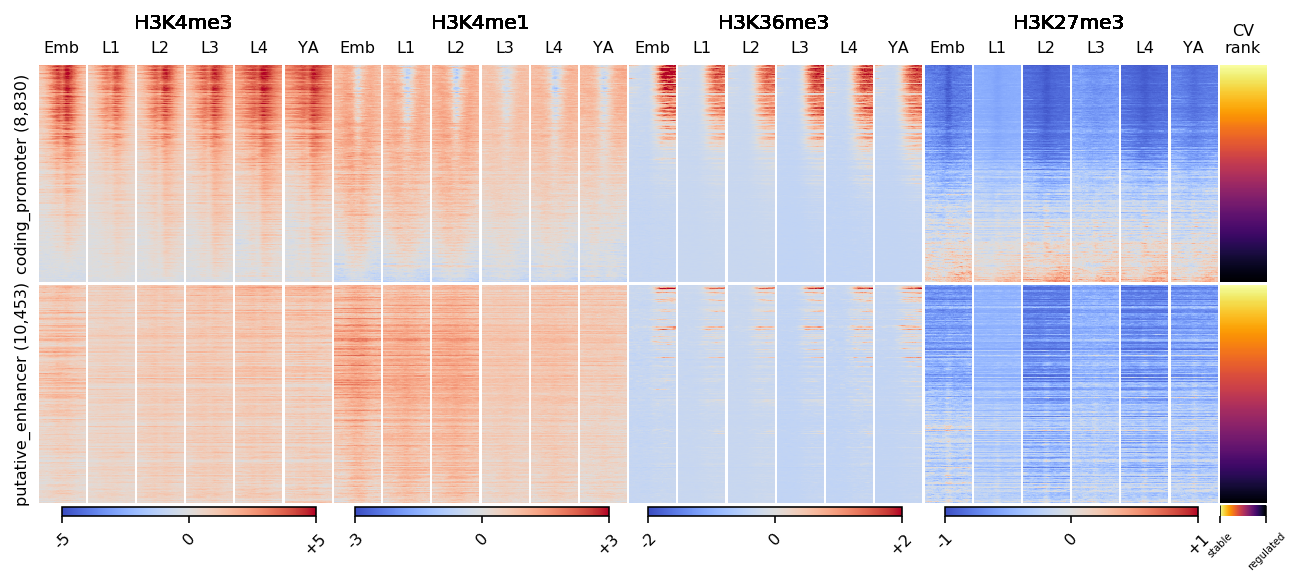

In [6]:
row_labels_ = [
    'coding_promoter (%s)' % (yp.f_uk(len(gdf.r.query('(annot == "coding_promoter") & (CV == CV)'))),), 
    'putative_enhancer (%s)' % (yp.f_uk(len(gdf.r.query('(annot == "putative_enhancer") & (CV == CV)'))),),
]

gdf.query(q_)\
.sort(['annot', 'CV'])\
.imshow(
    figsize=(11, 3.8),
    savefig=False,
    kwargs_grid = {'cbar_size': '5%', 'cbar_pad': 0.02, 'axes_pad': 0.02,},
    axis_off=True,
    cluster_col='annot',
    nsquashed=200,
    vextent=1,
    suptitle='',
    row_labels=row_labels_,
    fontsize=8,
    #figB_magic=True,
    figB_suppl_magic=True,
    #l_title_cbar=['H3K4me3\nwt_emb', 'H3K4me1\nwt_emb', 'H3K27me3\nwt_emb','CV\nrank'],
    l_title_cbar=['H3K4me3\nwt_emb', 'H3K4me1\nwt_emb', 'H3K36me3_gene\nwt_emb', 'H3K27me3\nwt_emb','CV\nrank'],
)

fp_ = 'annot_Apr27/Fig3S1A_HMsortbyCV.png'
plt.savefig(fp_, dpi=600, transparent=True, bbox_inches='tight')